In [1]:
# Importar bibliotecas para análise
import pandas as pd

In [2]:
# Análise inicial da base de dados
df = pd.read_csv('base_teste.csv')
print(f'Linhas na base: {df.shape[0]}\nColunas na base: {df.shape[1]}')
df.head()

Linhas na base: 480863
Colunas na base: 10


,Unnamed: 0,cidade_retirada,cidade_devolucao,cd_contrato,transporte_locado,data_abertura_contrato,qtd_diarias,data_fechamento_contrato,qtd_hora_extra,cd_cliente
0,0,Hogsmeade,Hogsmeade,HGM048798,Portal,2015-01-26 05:58:37,1,2015-01-27 05:58:37,0,1
1,1,Springfield,Springfield,SPF030834,Ônibus Escolar,2015-02-05 15:10:19,1,2015-02-06 15:10:19,0,1
2,2,Porto Real,Porto Real,PRL017782,Barco,2015-05-04 20:49:56,1,2015-05-05 20:49:56,0,1
3,3,Basin City,Basin City,SIN042621,1960 Corvette,2015-05-07 07:34:04,1,2015-05-08 07:34:04,0,1
4,4,Godric's Hollow,Godric's Hollow,GDH044954,Testralio,2015-08-01 11:14:48,2,2015-08-03 12:14:48,1,1


In [3]:
# Formatos dos dados, provavlemente será necessário ajustar as Datas
df.dtypes

Unnamed: 0                   int64
cidade_retirada             object
cidade_devolucao            object
cd_contrato                 object
transporte_locado           object
data_abertura_contrato      object
qtd_diarias                  int64
data_fechamento_contrato    object
qtd_hora_extra               int64
cd_cliente                   int64
dtype: object

In [4]:
# Abertura de Contrato por Ano
df.data_abertura_contrato.str.split('-').str[0].value_counts().sort_index()

2015    80166
2016    79835
2017    80029
2018    80197
2019    80516
2020    80120
Name: data_abertura_contrato, dtype: int64

## A base de dados tem informações sobre os contratos abertos entre 2015 e 2020.

In [5]:
# Fechamento de Contrato por Ano
df.data_fechamento_contrato.str.split('-').str[0].value_counts().sort_index()

2015    79633
2016    79831
2017    80040
2018    80171
2019    80553
2020    80100
2021      535
Name: data_fechamento_contrato, dtype: int64

## Já em relação ao fechamento dos contrato, o período vai de 2015 à 2021. Entretando, não será possível avaliar o churn rate em 2015 e 2021, seguindo as premissas consideradas para a análise. Segundo os critérios determinados não será possível calcular a taxa para os clientes ativos em 2015, assim como não será possível calcular a taxa para 2021, uma vez que o período considerado ainda não foi finalizado.

In [6]:
# Quantidade de Clientes únicos na Base
len(df.cd_cliente.unique())

44842

## Considerando que são apenas 44.482 clientes na base e que estão regustradas 480.863 contratações, fica evidente que vários clientes realizaram contratações várias vezes no mesmo ano e também ao longo dos anos. 

In [7]:
# Contratação Média por Cliente
print((df.shape[0])/len(df.cd_cliente.unique()))

10.723495829802417


In [8]:
# Duração dos Contratos
df.qtd_diarias.value_counts().sort_values().head(5)

23    1
26    1
24    1
20    5
21    6
Name: qtd_diarias, dtype: int64

## Bom, como o contrato de maior duração reguistrado na base tem 23 dias, não será necessário considerar o mês, o dia e o horário do contrato para a análise de churn. Dessa forma, será considerado apenas o ano em quem o contrato foi iniciado, de forma que fica implicito que o contrato foi encerrado no mesmo ano.

In [9]:
# Ciar nova coluna com o Ano da Contratação
df['Ano_Contratação'] = df.data_fechamento_contrato.str.split('-').str[0]
df.head()

,Unnamed: 0,cidade_retirada,cidade_devolucao,cd_contrato,transporte_locado,data_abertura_contrato,qtd_diarias,data_fechamento_contrato,qtd_hora_extra,cd_cliente,Ano_Contratação
0,0,Hogsmeade,Hogsmeade,HGM048798,Portal,2015-01-26 05:58:37,1,2015-01-27 05:58:37,0,1,2015
1,1,Springfield,Springfield,SPF030834,Ônibus Escolar,2015-02-05 15:10:19,1,2015-02-06 15:10:19,0,1,2015
2,2,Porto Real,Porto Real,PRL017782,Barco,2015-05-04 20:49:56,1,2015-05-05 20:49:56,0,1,2015
3,3,Basin City,Basin City,SIN042621,1960 Corvette,2015-05-07 07:34:04,1,2015-05-08 07:34:04,0,1,2015
4,4,Godric's Hollow,Godric's Hollow,GDH044954,Testralio,2015-08-01 11:14:48,2,2015-08-03 12:14:48,1,1,2015


## É preciso criar uma função para calcular a taxa de churn para Clientes Ativos e Clientes Novos, a cada ano, seguindo os critérios definidos.

In [93]:
# Função para calcular o Churn Rate para Clientes Ativos e Novos Clientes
def calcular_churn(lista):
    ano_anterior = lista[0] 
    ano_atual = lista[1]

    total_anterior = int(len(df.loc[df.Ano_Contratação == ano_anterior]['cd_cliente'].unique()))
    clientes_ativos_anterior = list(df.loc[df.Ano_Contratação == ano_anterior]['cd_cliente'].unique())
    df_atual = df.loc[df.Ano_Contratação == ano_atual]
    clientes_ativos_atual = df_atual[df_atual['cd_cliente'].isin(clientes_ativos_anterior)]
    clientes_ativos_atual = len(clientes_ativos_atual.cd_cliente.unique())
    churn_clientes_ativos = round(((total_anterior - int(clientes_ativos_atual)) / total_anterior) * 100, 2)

    df_novos_atual = df_atual[~df_atual['cd_cliente'].isin(clientes_ativos_anterior)]
    clientes_novos_atual = int(len(df_novos_atual.cd_cliente.unique()))
    recorrente_atual = df_novos_atual['cd_cliente'].duplicated(keep='first').sum()
    churn_novos_clientes = round(((recorrente_atual / clientes_novos_atual) * 100), 2)

    resultado_período = {'Ano': [lista[1]], 'Churn_Clientes_Ativos': [churn_clientes_ativos], 'Churn_Novos_Clientes': [churn_novos_clientes]}
    resultado_período = pd.DataFrame.from_dict(resultado_período)
    
    return resultado_período

In [94]:
# Aplicar a função à Base e retornar os Churn Rate de cada período em um Dataframe
períodos = [['2015','2016'], ['2016', '2017'], ['2017', '2018'], ['2018', '2019'], ['2019', '2020']]
df_final = pd.DataFrame(columns=['Ano', 'Churn_Clientes_Ativos', 'Churn_Novos_Clientes'])
for período in períodos:
    df_final = df_final.append(calcular_churn(período))
df_final

,Ano,Churn_Clientes_Ativos,Churn_Novos_Clientes
0,2016,25.88,44.49
0,2017,25.87,44.58
0,2018,25.60,43.79
0,2019,25.81,42.94
0,2020,26.10,45.94


## Fica bem claro, através da comparação do churn rate nos períodos, que a hispótese de que **"O churn de novos clientes é maior do que o churn de clientes ativos"** é **verdadeira!**

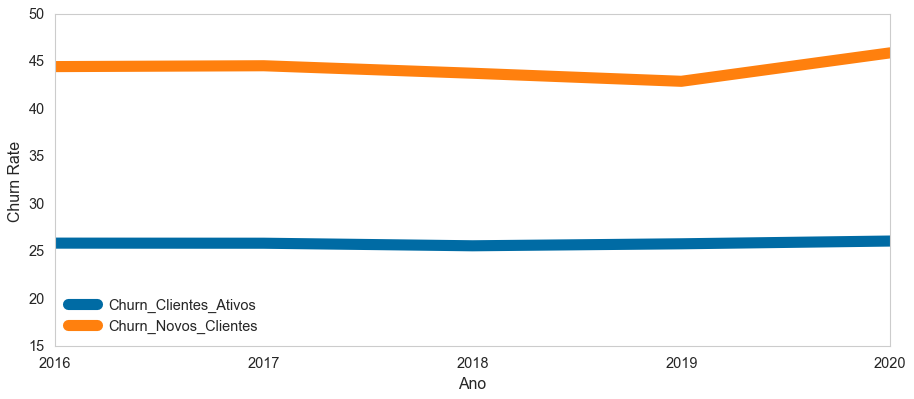

In [163]:
# Plotar comparativo entre Grupos de Clientes
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
df_final.plot(x="Ano", figsize=(12,5), linewidth=10, ylim=(15,50), ylabel="Churn Rate").grid(b=None)